In [4]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# CONFIGURATION
DATA_PATH = 'transport'  
IMG_SIZE = 64          # Fixed size (64x64 pixels)
CLASSES = ['Cars', 'Bike']

def load_and_process_data(data_path):
    data = []
    
    # Check if main directory exists
    if not os.path.exists(data_path):
        print(f"Error: Directory '{data_path}' not found.")
        return None, None

    for label_name in CLASSES:
        path = os.path.join(data_path, label_name)
        class_num = CLASSES.index(label_name) # 0 for Cars, 1 for Bikes
        
        # Check if class folder exists
        if not os.path.exists(path):
            print(f"Warning: Folder '{label_name}' not found in {data_path}")
            continue

        print(f"Loading {label_name}...")
        for img_name in os.listdir(path):
            try:
                # Load image in RGB
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                
                # Resize
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                
                # Append [image, label]
                data.append([new_array, class_num])
            except Exception as e:
                pass # Skip corrupt images

    # Shuffle the data to mix Cars and Bikes
    random.shuffle(data)

    X = []
    y = []

    for features, label in data:
        X.append(features)
        y.append(label)

    # Convert to Numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Flatten X: (Num_Images, 64, 64, 3) -> (Num_Images, 12288)
    X_flatten = X.reshape(X.shape[0], -1).T
    
    # Reshape y to (1, Num_Images)
    y = y.reshape(1, y.shape[0])
    
    # Normalize pixel values (0-255 -> 0-1)
    X_flatten = X_flatten / 255.0
    
    return X_flatten, y

# Load the data
print("Processing data...")
X_all, y_all = load_and_process_data(DATA_PATH)

if X_all is not None:
    print(f"\nData Shape: {X_all.shape}")
    print(f"Labels Shape: {y_all.shape}")

Processing data...
Loading Cars...
Loading Bike...

Data Shape: (12288, 785)
Labels Shape: (1, 785)


In [5]:
def train_test_split_manual(X, y, split_ratio=0.8):
    m = X.shape[1] # Number of examples
    split_idx = int(m * split_ratio)
    
    # Split
    X_train = X[:, :split_idx]
    y_train = y[:, :split_idx]
    
    X_test = X[:, split_idx:]
    y_test = y[:, split_idx:]
    
    return X_train, y_train, X_test, y_test

if X_all is not None:
    X_train, y_train, X_test, y_test = train_test_split_manual(X_all, y_all)
    print(f"Train Set: {X_train.shape[1]} samples")
    print(f"Test Set: {X_test.shape[1]} samples")

Train Set: 628 samples
Test Set: 157 samples


In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def initialize_parameters(dim):
    # Initialize weights as zeros (dim, 1) and bias as 0
    w = np.zeros((dim, 1))
    b = 0.0
    return w, b

In [7]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    # 1. Calculate activation A = sigmoid(w.T * X + b)
    A = sigmoid(np.dot(w.T, X) + b)
    
    # 2. Compute Cost
    # Adding a tiny epsilon to log to prevent log(0) errors
    epsilon = 1e-15
    cost = -1/m * np.sum(Y * np.log(A + epsilon) + (1-Y) * np.log(1-A + epsilon))
    
    # BACKWARD PROPAGATION (TO FIND GRADIENTS)
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [8]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    
    for i in range(num_iterations):
        # Calculate gradients and cost
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives
        dw = grads["dw"]
        db = grads["db"]
        
        # Update Rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the cost
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost}")
                
    params = {"w": w, "b": b}
    return params, costs

In [9]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute probability vector
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        # Convert probabilities to actual predictions (0 or 1)
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
            
    return Y_prediction

Cost after iteration 0: 0.6931471805599434
Cost after iteration 100: 0.6337180756493904
Cost after iteration 200: 0.6087140185516705
Cost after iteration 300: 0.5898640518247169
Cost after iteration 400: 0.5743277731154189
Cost after iteration 500: 0.5609676482035824
Cost after iteration 600: 0.5491849320148214
Cost after iteration 700: 0.5386114290140991
Cost after iteration 800: 0.5289989800752396
Cost after iteration 900: 0.5201705254472468
Cost after iteration 1000: 0.5119946904303583
Cost after iteration 1100: 0.5043710713432563
Cost after iteration 1200: 0.49722108929263364
Cost after iteration 1300: 0.49048202250031964
Cost after iteration 1400: 0.4841029688217692
Cost after iteration 1500: 0.47804203198840806
Cost after iteration 1600: 0.4722643096622509
Cost after iteration 1700: 0.4667404215416231
Cost after iteration 1800: 0.461445410245564
Cost after iteration 1900: 0.4563579053693323
------------------------------------------------
train accuracy: 85.03184713375796 %
test 

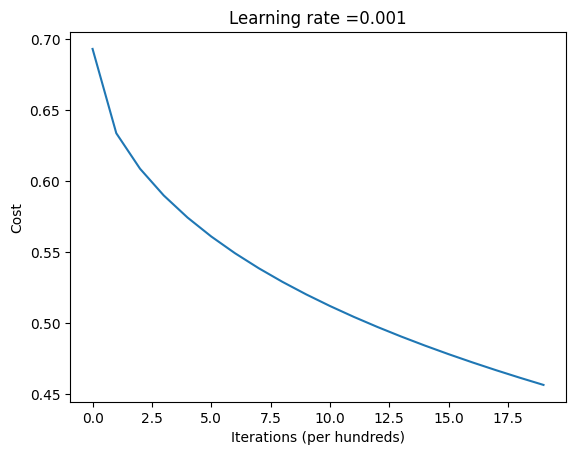

In [10]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.005):
    # 1. Initialize parameters
    w, b = initialize_parameters(X_train.shape[0])
    
    # 2. Gradient Descent
    parameters, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost=True)
    
    # Retrieve parameters
    w = parameters["w"]
    b = parameters["b"]
    
    # 3. Predict on Train and Test sets
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # 4. Print Accuracy
    print("------------------------------------------------")
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    print("------------------------------------------------")

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

# --- EXECUTE THE MODEL ---
if X_all is not None:
    logistic_regression_model = model(X_train, y_train, X_test, y_test, 
                                      num_iterations=2000, 
                                      learning_rate=0.001)

    # --- PLOT THE COST GRAPH ---
    costs = np.squeeze(logistic_regression_model['costs'])
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per hundreds)')
    plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
    plt.show()